# Estimating object location from noisy radar echos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [2]:
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv

## Useful utility functions

In [3]:
# Plot 'iso-densities' for MVN
#   ax - axis for plotting,
#   mu, Sigma - MVN parameters,
#   observations - observations (data points) to mark on the plot,
#   title - plot title.
def plot_mvn(ax, mu, Sigma, observations = None, title = None,
             xmin=-10, xmax=10, ymin=-10, ymax=10, grid_size = 100):
    X = np.linspace(xmin, xmax, grid_size)
    Y = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(X, Y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T
    
    p = mvn(mu, Sigma)
    density = p.pdf(grid).reshape((grid_size, grid_size))

    ax.contour(X, Y, density, zorder=1)
    
    if observations is not None:
        if len(observations.shape) == 1:
            ox, oy = observations[0], observations[1]
        else:
            ox, oy = observations[:, 0], observations[:, 1]
            
        ax.scatter(ox, oy, s=100, c='r', marker='x', zorder=2)
    
    if title is not None:
        ax.set_title(title)
    
    ax.axis('equal')
    plt.show

## Estimating object location from (one) noisy radar echo

Our task is to estimate location of a stationary object from its radar echo.

Assumptions:
- radar plane is a $[-10, 10] \times [-10, 10]$ rectangle,
- radar echo gives us a noisy measurement of the true location,
- the measurement noise is well modeled by a multivariate Gaussian with precision: `radar_echo_Prec`.

In [4]:
radar_echo_Sigma = np.array([[2, -1.5],
                             [-1.5, 2]])

radar_echo_Prec = inv(radar_echo_Sigma)

For now, we have only one radar echo to work with. It is stored in: `radar_echo`.

In the code below, `true_x` is the true location of the object on the radar plane. We imagine that we do not know this location (our task is to estimate it).

In [5]:
true_x = np.array([5.0, 5.0])

radar_echo = mvn.rvs(true_x, radar_echo_Sigma, size=1, random_state=1234)

---

Propose (and be ready do justify) a probabilistic model for estimating object location from the radar echo. This model must:
1. estimate a likely location of the object,
1. estimate uncertainty in the (estimated) object location.

From working experience with our radar we know that objects are most often located in a sphere with radius $r=3$ centered in the radar plane.

---

Implement the proposed model in `estimate_location_from_echo` function. The arguments to this function should be:
- radar echo,
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo` should return parameters of the probability distribution that expresses our beliefs about object location after observing one radar echo.

Assumptions:<br>
`radar_echo_Sigma` - covariation matrix of the radar, $\Sigma_y$ <br>
Prior:<br>
`x` is given with MVN with parameters $\mu_x = [0, 0]$ and $\Sigma_x = \begin{bmatrix}
  3 & 0\\ 
  0 & 3
\end{bmatrix}$ 

So Gaussian model is:
$$ y = Ax + b + \epsilon $$
but our radar messurment does not need any affine transformation, so we can substitue:
$$A = \begin{bmatrix}
  1 & 0\\ 
  0 & 1
\end{bmatrix} $$
$$b = [0, 0] $$
$$ x \sim \mathcal{N}\left([0, 0],  \begin{bmatrix}
  3 & 0\\ 
  0 & 3
\end{bmatrix}\right) $$
$$ \epsilon \sim \mathcal{N}\left([0, 0],  \begin{bmatrix}
  2 & -1.5\\ 
  -1.5 & 2
\end{bmatrix}\right) $$ 
From gaussian model we can get distribution of x over y:
$$ x | y \sim \mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$$
Where:
$$ \Sigma_{x|y} = [\Sigma_x^{-1} + A^T\Sigma_y^{-1}A]^{-1} $$
$$ \mu_{x | y} = \Sigma_{x|y}[A^T\Sigma_y^{-1}(y-b) + \Sigma_x^{-1}\mu_x] $$


In [6]:
mu_x = np.array([0,0])
sigma_x = np.array([[3, 0], [0, 3]])
A = np.array([[1, 0], [0, 1]])
b = np.array([0, 0])

In [7]:
def estimate_location_from_echo(radar_echo, radar_echo_Sigma, mu_x, sigma_x, affine_A, affine_b):
    sigma_x_inv = inv(sigma_x)
    sigma_y_inv = inv(radar_echo_Sigma)
    affine_A_transposed = affine_A.transpose()

    sigma_x_y = inv(sigma_x_inv + affine_A_transposed @ sigma_y_inv @ affine_A)
    mu_x_y = sigma_x_y @ (affine_A_transposed @ sigma_y_inv @ (radar_echo - affine_b) + sigma_x_inv @ mu_x)
    
    return mu_x_y, sigma_x_y

Now, use `estimate_location_from_echo` to estimate object location (and uncertainty). Then use `plot_mvn` function to plot two 'iso-density' plots:
- one for our prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include location of the radar echo.

mu = [3.48745762 4.06313464], sigma = [[ 1.02197802 -0.59340659]
 [-0.59340659  1.02197802]]


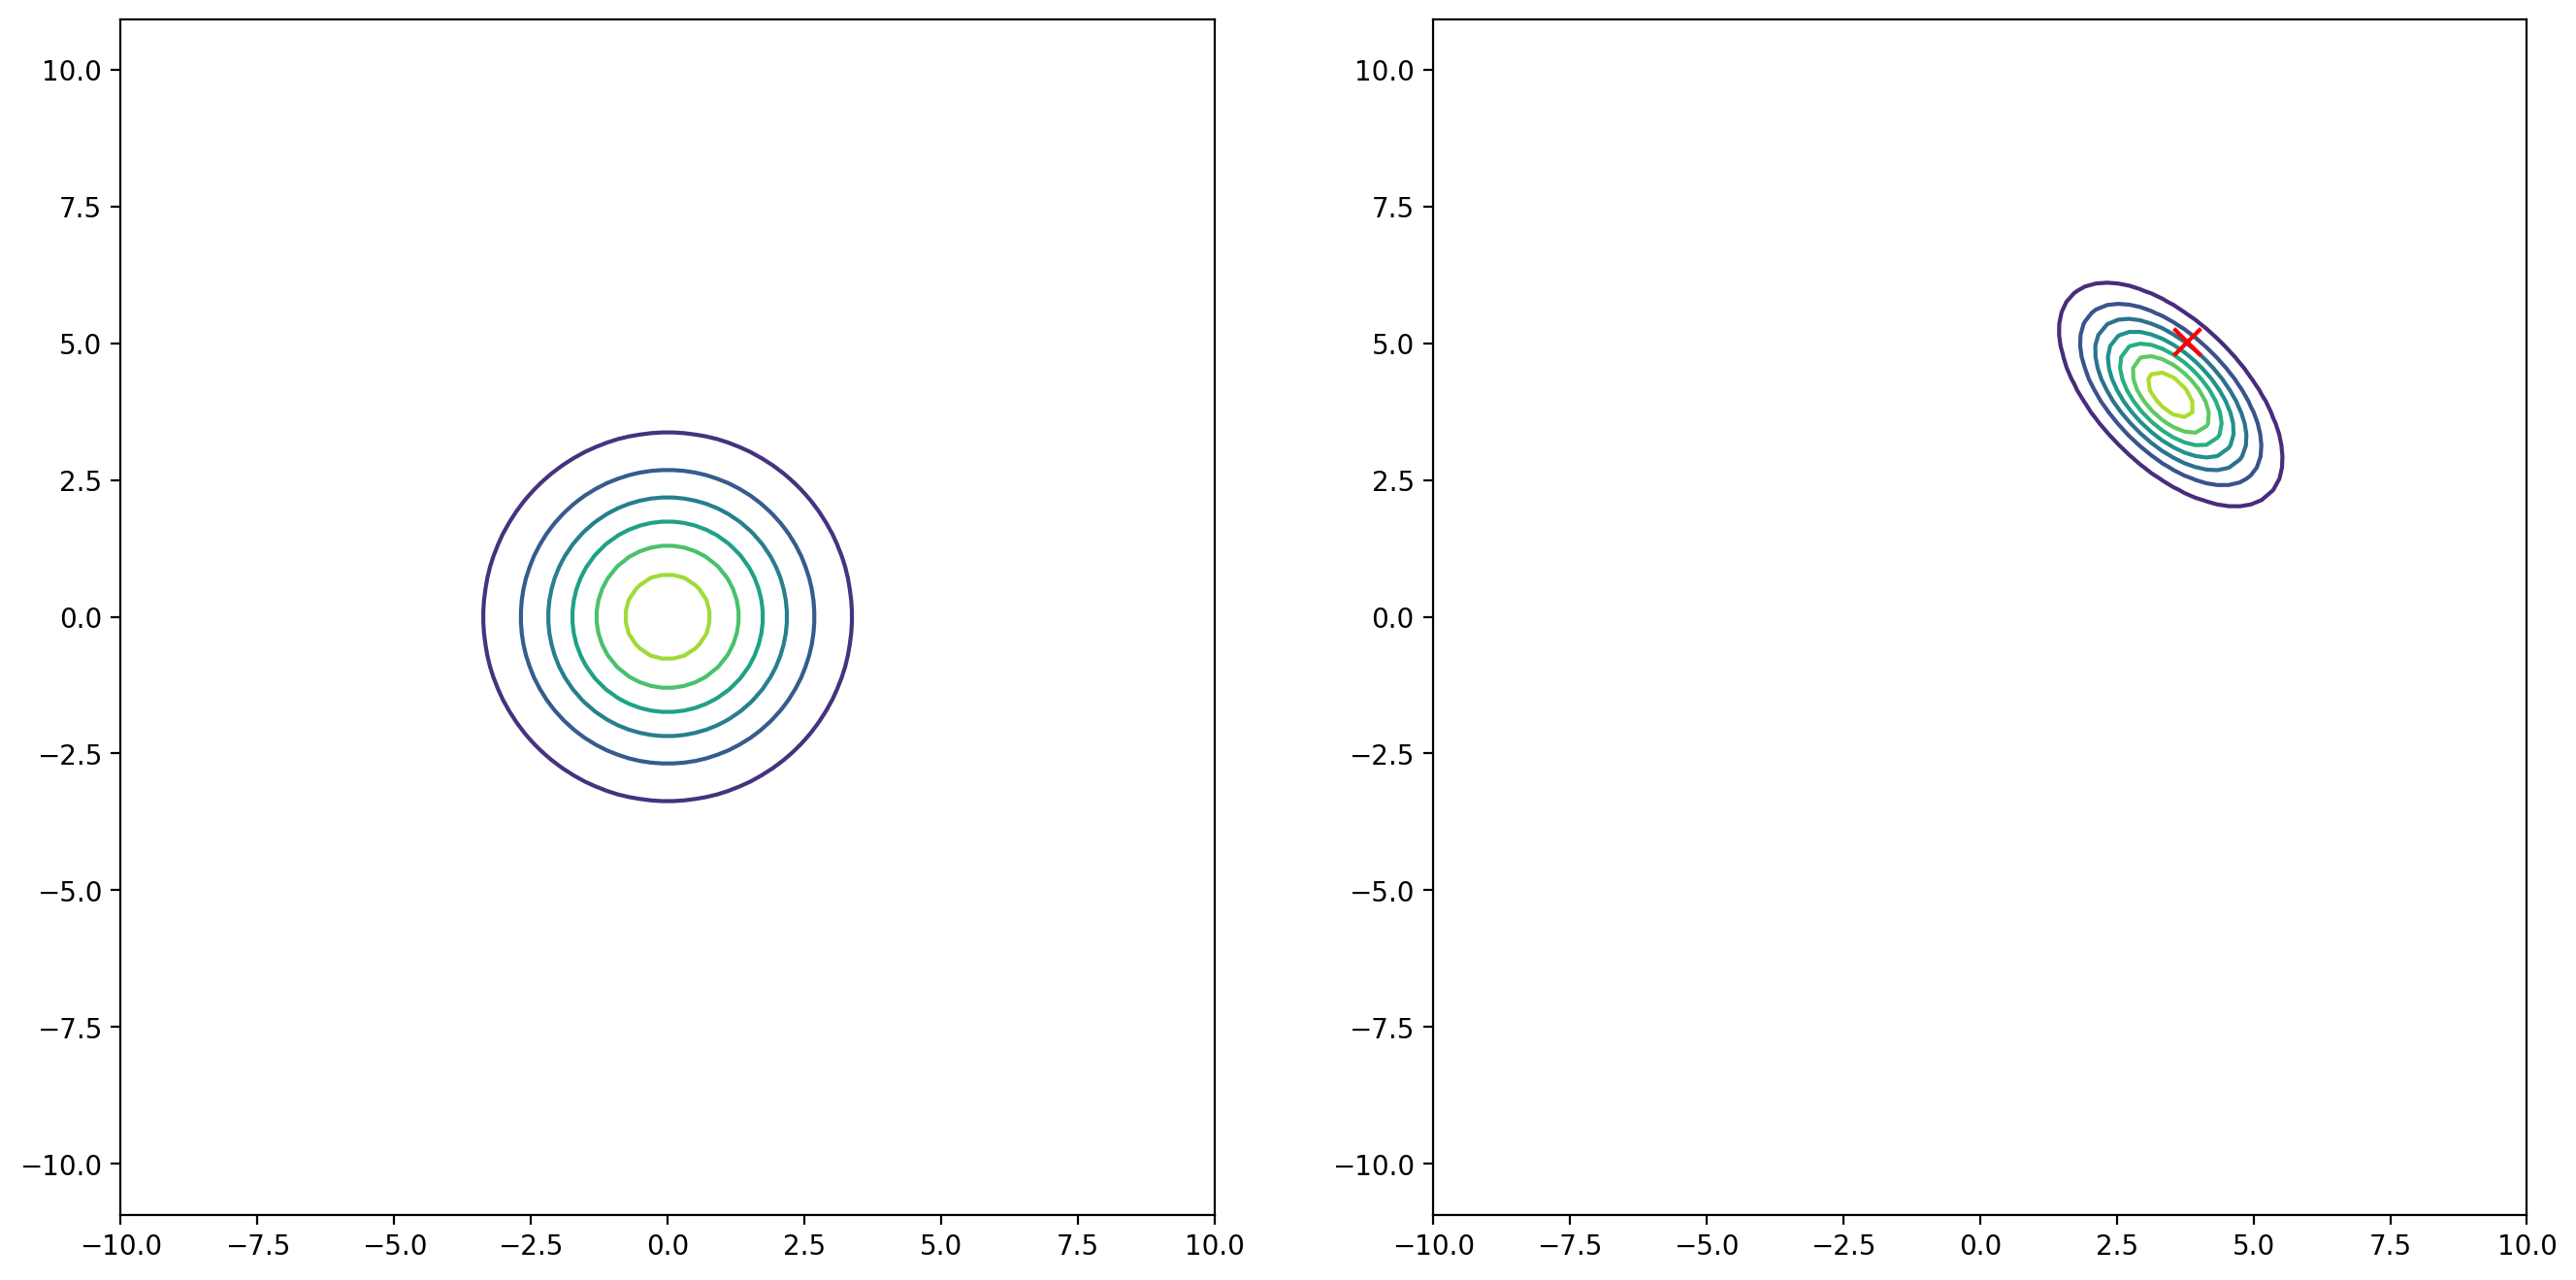

In [8]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

mu_location, sigma_location = estimate_location_from_echo(radar_echo, radar_echo_Sigma, mu_x, sigma_x, A, b)
print(f"mu = {mu_location}, sigma = {sigma_location}")

plot_mvn(ax[0], mu_x, sigma_x)
plot_mvn(ax[1], mu_location, sigma_location, observations=radar_echo)

## Estimating object location from multiple noisy radar echos

Now imagine that we have $N$ radar echos for a single object (we made $N$ independent radar scans). These echos are stored in `radar_echo_n`.

In [9]:
N=5

radar_echo_n = mvn.rvs(true_x, radar_echo_Sigma, size=N, random_state=1234)

Our goal is to estimate object location (and uncertainty) from all these radar scans. One simple option is to iteratively update our beliefs about object location as new echos arrive.

That is:
- we start with prior assumptions about object location,
- we update our beliefs about object location when we observe a radar echo,
- once we observe another radar echo, we can treat our current beliefs about object location (estimated above) as prior assumptions,
- we can continue in this iterative manner until we accounted for evidence from all observed echos.

---

Implement the iterative procedure described above to estimate object location (and uncertainty) from all radar echos stored in `radar_echo_n`. Use `estimate_location_from_echo` function for updating beliefs about object location.

In [10]:
def estimate_location_from_multiple_echos(radar_echo_n, radar_echo_Sigma, mu_x, sigma_x, affine_A, affine_b):
    # start with prior assumptions
    mu_prior = mu_x
    sigma_prior = sigma_x 

    for radar_echo in radar_echo_n:
        mu_location, sigma_location = estimate_location_from_echo(radar_echo, radar_echo_Sigma, mu_prior, sigma_prior, affine_A, affine_b)

        # update prior assumptions
        mu_prior = mu_location
        sigma_prior = sigma_location

    # final result was stored at prior data during last iteration
    return mu_prior, sigma_prior


Use `plot_mvn` function to plot two 'iso-density' plots:
- one for prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include locations of all radar echos stored in `radar_echo_n`.

mu = [4.05875599 4.94208147], sigma = [[ 0.33217088 -0.23539669]
 [-0.23539669  0.33217088]]


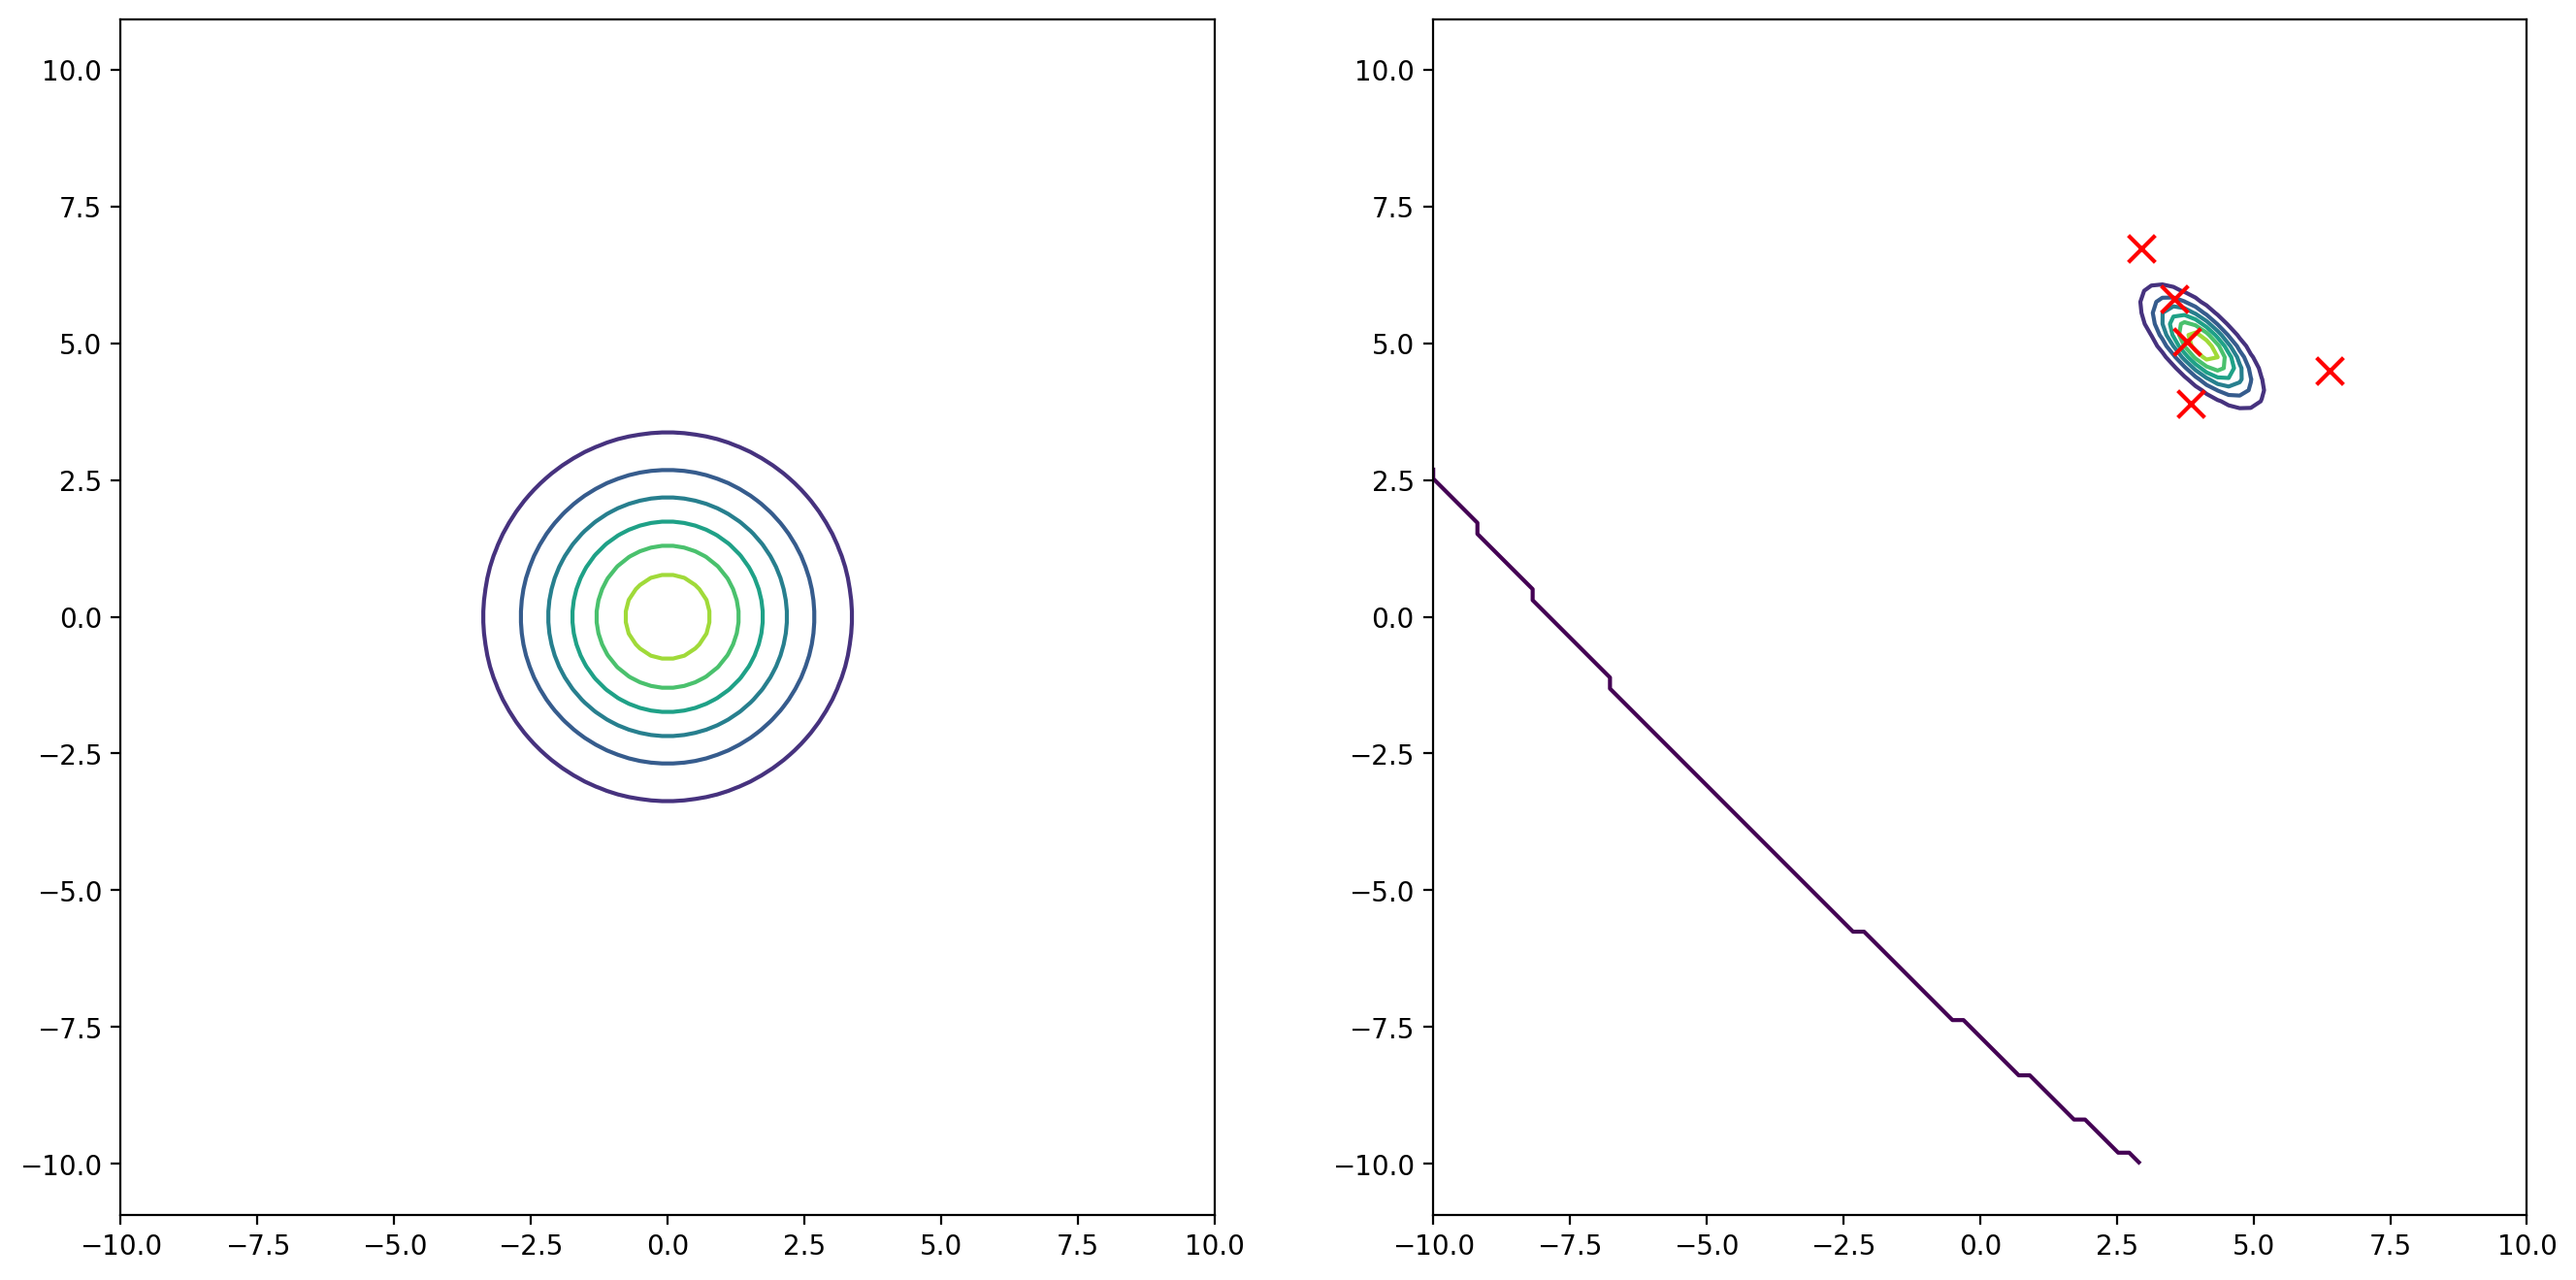

In [11]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

mu_location, sigma_location = estimate_location_from_multiple_echos(radar_echo_n, radar_echo_Sigma, mu_x, sigma_x, A, b)
print(f"mu = {mu_location}, sigma = {sigma_location}")

plot_mvn(ax[0], mu_x, sigma_x)
plot_mvn(ax[1], mu_location, sigma_location, observations=radar_echo_n)

In [25]:
# maximum aposteriori error 
map_point = mu_location
print(np.sqrt((true_x[0]-map_point[0])**2 + (true_x[1]-map_point[1])**2))

0.9430243074483172


The iterative update procedure implemented above has one drawback - it's not efficient (computationally).

If you came up with a sensible probabilistic model it should be possible to derive equations for estimating object location (and uncertainty) from all radar echos (in a single pass). Try to write down these equations and implement them in `estimate_location_from_echo_batch` function. The arguments to this function should be:
- radar echos (in a NumPy array),
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo_batch` should return parameters of the probability distribution that expresses our beliefs about object location after observing all radar echos.

---

Hint: try to write down parameters of the probability distribution over object location after:
- observing one echo, e.g. $e_1$,
- then observing another echo, e.g. $e_2$.

Guess a form of the batch-update equations from these examples. Then prove by induction that it is correct.

In [12]:
def estimate_location_from_echo_batch(radar_echo_n, radar_echo_Sigma, mu_x, sigma_x, affine_A, affine_b):
    sigma_x_inv = inv(sigma_x)
    sigma_y_inv = inv(radar_echo_Sigma)
    affine_A_transposed = affine_A.transpose()

    n = len(radar_echo_n)
    
    sigma_x_y_n = inv(sigma_x_inv + n * (affine_A_transposed @ sigma_y_inv @ affine_A))
    mu_x_y_n = sigma_x_y_n @ (affine_A_transposed @ sigma_y_inv @ (np.sum(radar_echo_n, axis=0) - n*affine_b) + sigma_x_inv @ mu_x)

    return mu_x_y_n, sigma_x_y_n

Use `estimate_location_from_echo_batch` to estimate object location (and uncertainty) from all radar echos.

Next, use `plot_mvn` function to make 'iso-density' plots identical to the ones above, but using location and uncertainty estimates from `estimate_location_from_echo_batch`.

Verify that estimates from `estimate_location_from_echo_batch` agree with the ones from the iterative update procedure.

mu = [4.05875599 4.94208147], sigma = [[ 0.33217088 -0.23539669]
 [-0.23539669  0.33217088]]


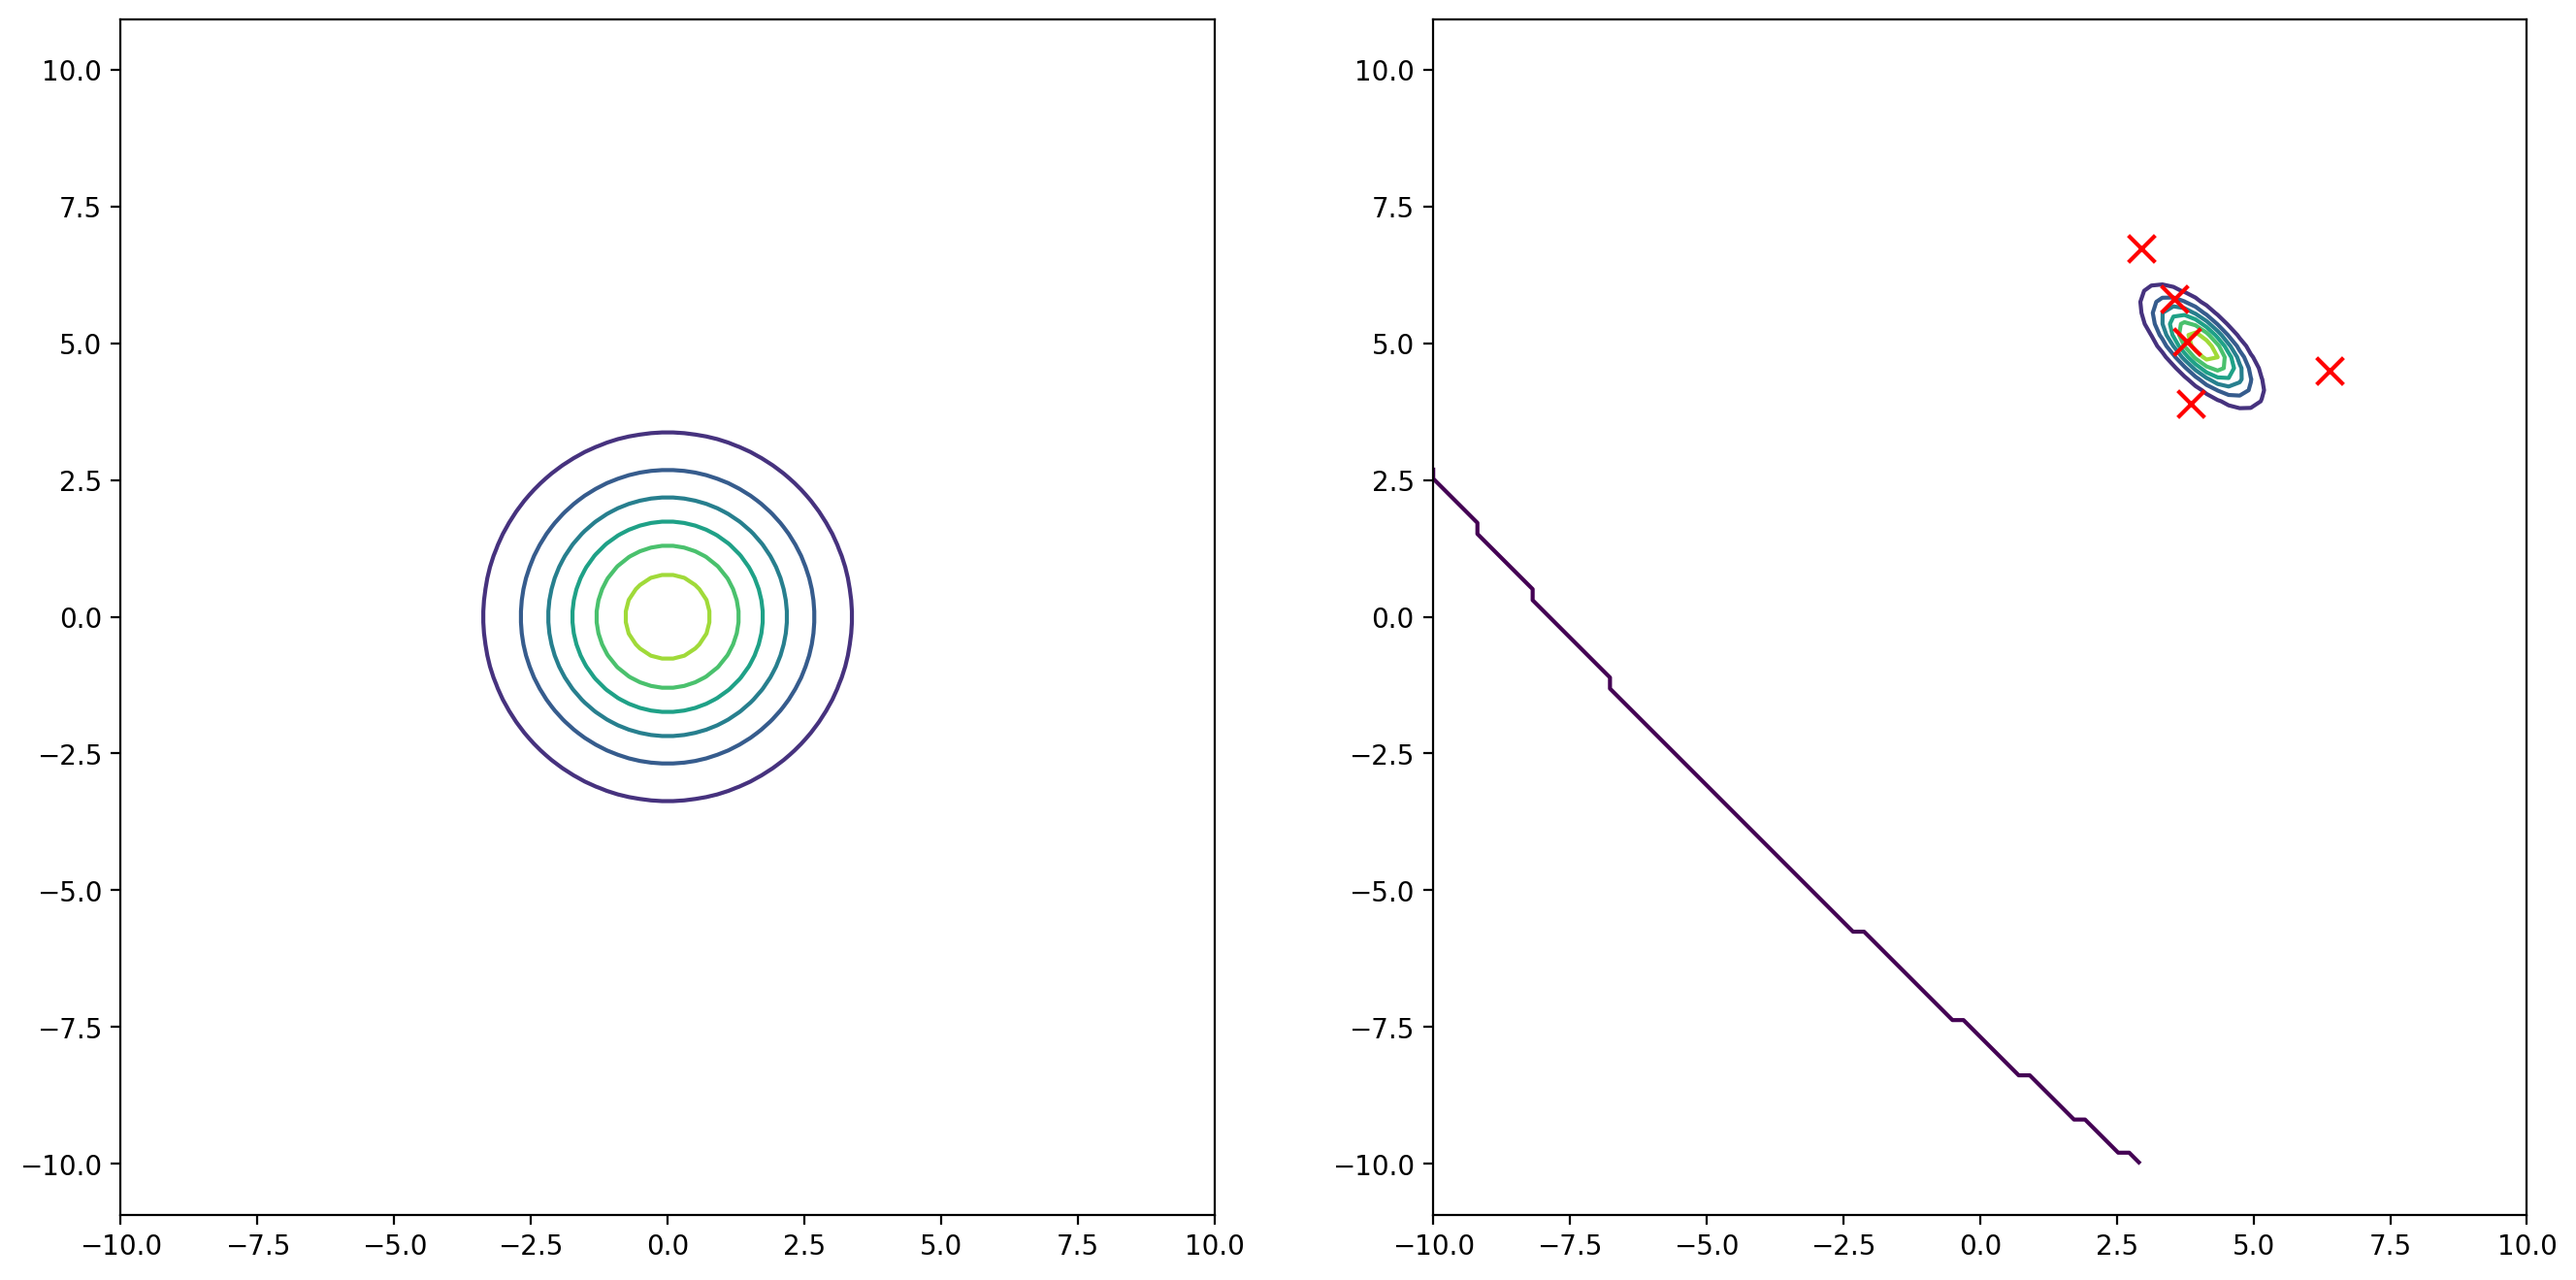

In [13]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

mu_location, sigma_location = estimate_location_from_echo_batch(radar_echo_n, radar_echo_Sigma, mu_x, sigma_x, A, b)
print(f"mu = {mu_location}, sigma = {sigma_location}")

plot_mvn(ax[0], mu_x, sigma_x)
plot_mvn(ax[1], mu_location, sigma_location, observations=radar_echo_n)

I will assume following notation:
<ol>
    <li>$\large \Sigma_{x|y}^{(n)}$ - covariance matrix after $n$ observations, describes final posterior </li>
    <li>$\large \mu_{x|y}^{(n)}$ - mean vector after $n$ observations, describes final posterior </li>
    <li>$\large \Sigma_{x|y}^{(0)} = \Sigma_x $ - covariance matrix - our prior assumption </li>
    <li>$\large \mu_{x|y}^{(0)} = \mu_x $ - mean vector - our prior assumption </li>
</ol>
I will refer to those general assumptions with (1), (2), (3), (4)

Iterative solution uses following definitions to update prior assumptions:
$$\large \Sigma_{x|y}^{(n)} \stackrel{def}{=} \left[\Sigma_x^{n - 1} + A^T\Sigma_y^{-1}A\right]^{-1} $$
$$\large \mu_{x|y}^{(n)} \stackrel{def}{=} \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_n - b) + \Sigma_{x|y}^{(n - 1)} \mu_{x | y}^{(n-1)}\right] $$

Lets try to figure out cumulative solution for n observations. <br>
I start with covariance matrix. We can write down some examples according to iterative definition and we might see the pattern.
<ol>
    <li> $ \Sigma_{x|y}^{(1)} = \left[\left(\Sigma_{x|y}^{(0)}\right)^{-1} + A^T \Sigma_y^{-1} A  \right]^{-1} = \left[\Sigma_x^{-1} + A^T \Sigma_y^{-1} A \right]^{-1}$ </li>
    <li> $ \Sigma_{x|y}^{(2)} = \left[\left(\Sigma_{x|y}^{(1)}\right)^{-1} + A^T \Sigma_y^{-1} A \right]^{-1} = 
        \left[\left(\left[\Sigma_x^{-1} + A^T \Sigma_y^{-1} A \right]^{-1}\right)^{-1} + A^T \Sigma_y^{-1} A \right]^{-1} = 
        \left[\Sigma_x^{-1} + 2A^T \Sigma_y^{-1} A \right]^{-1}$ </li>
    <li> $ \Sigma_{x|y}^{(3)} = \left[\left(\Sigma_{x|y}^{(2)}\right)^{-1} + A^T \Sigma_y^{-1} A \right]^{-1} = \left[\Sigma_x^{-1} + 3A^T \Sigma_y^{-1} A \right]^{-1}$ </li>
</ol>

We can see a pattern, so maybe the solution is:
$$\large \Sigma_{x|y}^{(n)} = \left[\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A\right]^{-1} $$
Let's prove it with induction: 
<ul>
    Definition: $\Sigma_{x|y}^{(n)} \stackrel{def}{=} \left[\Sigma_x^{(n - 1)} + A^T\Sigma_y^{-1}A\right]^{-1}$ <br>
    Thesis: $\Sigma_{x|y}^{(n)} = \left[\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A\right]^{-1} $ <br>
    <br>
    I. $n = 1$
    $$\Sigma_{x|y}^{(1)} \stackrel{def}{=} \left[\left(\Sigma_x^{(0)}\right)^{-1} + A^T\Sigma_y^{-1}A\right]^1 \stackrel{\text{(3)}}{=} \left[ E_x^{-1} + A^T\Sigma_y^{-1}A \right]^{-1} $$
    $$\text{Definition} = \text{Thesis}$$
    II. Induction step
    <ul>
        Assumption: $\Sigma_{x|y}^{(n)} = \left[\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A\right]^{-1} $ <br>
        Thesis: $\Sigma_{x|y}^{(n + 1)} = \left[\Sigma_x^{-1} + (n+1)A^T\Sigma_y^{-1}A\right]^{-1} $ <br>
        <br>
        We can start with definitiun, substitute induction assumption and get to induction thesis.
        $$ \Sigma_{x|y}^{(n + 1)} \stackrel{def}{=} \left[\left(\Sigma_{x|y}^{(n)}\right)^{-1} + A^T\Sigma_y^{-1}A \right]^{-1} \stackrel{assumption}{=} 
        \left[\left[\left(\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A\right)^{-1}\right]^{-1} + A^T\Sigma_y^{-1}A\right]^{-1} = \left[\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A + A^T\Sigma_y^{-1}A\right]^{-1} =
        \left[\Sigma_x^{-1} + (n+1)A^T\Sigma_y^{-1}A\right]^{-1} = \text{Thesis}
        $$
        $$ \text{Definition} = \text{Thesis} $$
    </ul>
    We have derived our thesis from definition what ends our induction proof.
</ul>

Now let's move to mean vector. Again I will write down few terms from definition:

<ol>
    <li> $ \large \mu_{x|y}^{(1)} = \Sigma_{x|y}^{(1)}\left[ A^T \Sigma_y^{-1}(y_1-b) + \left(\Sigma_{x|y}^{(0)}\right)^{-1}\mu_{x|y}^{(0)} \right] 
        = \Sigma_{x|y}^{(1)}\left[ A^T \Sigma_y^{-1}(y_1-b) + \Sigma_x^{-1}\mu_x \right] $ </li>
    <li> $ \large \mu_{x|y}^{(2)} = \Sigma_{x|y}^{(2)}\left[ A^T \Sigma_y^{-1}(y_2-b) + \left(\Sigma_{x|y}^{(1)}\right)^{-1}\mu_{x|y}^{(1)} \right] 
        = \Sigma_{x|y}^{(2)}\left[ A^T \Sigma_y^{-1}(y_2-b) + \left(\Sigma_{x|y}^{(1)}\right)^{-1}\Sigma_{x|y}\left[ A^T \Sigma_y^{-1}(y_1-b) + \Sigma_x^{-1}\mu_x \right] \right]$
        $ = \Sigma_{x|y}^{(2)}\left[ A^T \Sigma_y^{-1}(y_2-b) + A^T \Sigma_y^{-1}(y_1-b) + \Sigma_x^{-1}\mu_x \right] = 
        \Sigma_{x|y}^{(2)}\left[ A^T \Sigma_y^{-1}(y_2 + y_1 - 2b) + \Sigma_x^{-1}\mu_x \right] $ </li>
    <li> $ \large \mu_{x|y}^{(3)} = \Sigma_{x|y}^{(3)}\left[ A^T \Sigma_y^{-1}(y_3-b) + \left(\Sigma_{x|y}^{(2)}\right)^{-1}\mu_{x|y}^{(2)} \right] 
    = \Sigma_{x|y}^{(3)}\left[ A^T \Sigma_y^{-1}(y_3-b) + \left(\Sigma_{x|y}^{(2)}\right)^{-1}\Sigma_{x|y}^{(2)}\left[ A^T \Sigma_y^{-1}(y_2 + y_1 - 2b) + \Sigma_x^{-1}\mu_x \right] \right]
        $ 
        $  = \Sigma_{x|y}^{(3)}\left[ A^T \Sigma_y^{-1}(y_3-b) +   A^T \Sigma_y^{-1}(y_2 + y_1 - 2b) + \Sigma_x^{-1}\mu_x \right] 
         = \Sigma_{x|y}^{(3)}\left[ A^T \Sigma_y^{-1}(y_3 + y_2 + y_1 - 3b) + \Sigma_x^{-1}\mu_x \right]
        $
    </li>
</ol>
From above examples we can guess that cumulative equation should have following formula:

$$\large \mu_{x|y}^{(n)} = \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right] $$

We can prove it with induction, as for covariance matrix:
<ul>
    Definition: $ \mu_{x|y}^{(n)} \stackrel{def}{=} \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_n - b) + \left(\Sigma_{x|y}^{(n - 1)}\right)^{-1} \mu_{x | y}^{(n-1)}\right] $ <br>
    Thesis: $\mu_{x|y}^{(n)} = \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right] $ <br>
    <br>
    I. $n = 1$
    $$ \mu_x^{(1)} \stackrel{def}{=} \Sigma_{x|y}^{(1)}\left[ A^T\Sigma_y^{-1}(y_1 - b) + \left(\Sigma_{x|y}^{(0)}\right)^{-1}\mu_{x|y}^{(0)} \right] \stackrel{\text{(3), (4)}}{=} 
    \Sigma_{x|y}^{(1)}\left[ A^T\Sigma_y^{-1}(y_1 - b) + \Sigma_x^{-1}\mu_x\right] $$ 
    $$\text{Definition} = \text{Thesis}$$
    II.  Induction step
    <ul>
        Assumption: $\mu_{x|y}^{(n)} = \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right] $ <br>
        Thesis: $\mu_{x|y}^{(n + 1)} = \Sigma_{x|y}^{(n + 1)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n + y_{n+1} - (n + 1)b) + \Sigma_x^{-1} \mu_x\right] $ <br>
        <br>
        Like before, we can start from definition, use our induction assumption and get to our theseis.
        $$ \mu_{x|y}^{(n + 1)} \stackrel{def}{=} \Sigma_{x|y}^{(n + 1)}\left[A^T\Sigma_y^{-1}(y_{n + 1} - b) + \left(\Sigma_{x|y}^{(n)}\right)^{-1} \mu_{x | y}^{(n)}\right] \stackrel{assumption}{=} 
        \Sigma_{x|y}^{(n + 1)}\left[A^T\Sigma_y^{-1}(y_{n + 1} - b) + \left(\Sigma_{x|y}^{(n)}\right)^{-1}\Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right]\right] = $$
        $$ = \Sigma_{x|y}^{(n + 1)}\left[A^T\Sigma_y^{-1}(y_{n + 1} - b) + A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right] = 
         \Sigma_{x|y}^{(n + 1)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_{n + 1} - (n + 1)b) + \Sigma_x^{-1} \mu_x\right] = \text{Thesis}$$
        $$ \text{Definition} = \text{Thesis} $$
    </ul>
    We have derived our thesis from definition what ends our induction proof.
</ul>

To sum up, batch equations to get final posterior distribution parameters are:
 $$ \Sigma_{x|y}^{(n)} = \left[\Sigma_x^{-1} + nA^T\Sigma_y^{-1}A\right]^{-1} $$
$$\large \mu_{x|y}^{(n)} = \Sigma_{x|y}^{(n)}\left[A^T\Sigma_y^{-1}(y_1 + y_2 + ... + y_n - nb) + \Sigma_x^{-1} \mu_x\right] $$